# EPC Data Preprocessing

Data source:
    Scottish EPC: https://statistics.gov.scot/data/domestic-energy-performance-certificates

We selected 168410 EPC records for domestic buildings from October 2012 to March 2021 in Glasgoow, and filtered out the records whose coordinates fall outside the study area after geocoding. Then we got 165318 recoords.

In [2]:
import numpy as np 
import pandas as pd 
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import datetime
import glob
import json
import re

In [3]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [4]:
epc_all = pd.read_csv('epc_gla_footprint.csv')

In [5]:
epc_all.head(1)

,Unnamed: 0,original_gla_index,original_index,address_before_index,Property_UPRN,OSG_UPRN,ADDRESS1,ADDRESS2,POST_TOWN,Postcode,Flat Level,Flat Location,Total floor area (m2),Improvements,Primary Energy Indicator (kWh/m2/year),Current energy efficiency rating,Current energy efficiency rating band,Potential Energy Efficiency Rating,Potential energy efficiency rating band,Current Environmental Impact Rating,Current Environmental Impact Rating Band,Potential Environmental Impact Rating,Potential Environmental Impact Rating Band,WALL_DESCRIPTION,WALL_ENERGY_EFF,WALL_ENV_EFF,ROOF_DESCRIPTION,ROOF_ENERGY_EFF,ROOF_ENV_EFF,FLOOR_DESCRIPTION,FLOOR_ENERGY_EFF,FLOOR_ENV_EFF,WINDOWS_DESCRIPTION,WINDOWS_ENERGY_EFF,WINDOWS_ENV_EFF,MAINHEAT_DESCRIPTION,MAINHEAT_ENERGY_EFF,MAINHEAT_ENV_EFF,MAINHEATCONT_DESCRIPTION,MAINHEATC_ENERGY_EFF,MAINHEATC_ENV_EFF,SECONDHEAT_DESCRIPTION,SHEATING_ENERGY_EFF,SHEATING_ENV_EFF,HOTWATER_DESCRIPTION,HOT_WATER_ENERGY_EFF,HOT_WATER_ENV_EFF,LIGHTING_DESCRIPTION,LIGHTING_ENERGY_EFF,LIGHTING_ENV_EFF,AIR_TIGHTNESS_DESCRIPTION,AIR_TIGHTNESS_ENERGY_EFF,AIR_TIGHTNESS_ENV_EFF,CO2 Emissions Current Per Floor Area (kg.CO2/m2/yr),Current Emissions (T.CO2/yr),Potential Reduction in Emissions (T.CO2/yr),Total current energy costs over 3 years (¡ê),Potential future savings over 3 years (¡ê),Current heating costs over 3 years (_£),Potential heating costs over 3 years (_£),Current hot water costs over 3 years (_£),Potential hot water costs over 3 years (_£),Current lighting costs over 3 years (_£),Potential lighting costs over 3 years (_£),Alternative Measures,LZC Energy Source,Space Heating,Water Heating,Impact Of Loft Insulation,Impact Of Cavity Wall Insulation,Impact Of Solid Wall Insulation,Addendum Text,Part 1 Construction Age Band,Part 1 Floor 0 Room Height,Data Zone,Energy Consumption Potential,Extensions Count,Fixed Lighting Outlets Count,Low Energy Lighting Outlets Count,Low Energy Lighting %,Glazed Area,Habitable Room Count,Heat Loss Corridor,Heated Room Count,Local Authority,Main Gas,Main Heating 1 Category,Main Heating 1 Fuel Type,Main Heating 1 Control,Mechanical Ventilation,Meter Type,Multiple Glazed Proportion,Multiple Glazing Type,Open Fireplaces Count,Photovoltaic Supply,Solar Water Heating,Tenure,Transaction Type,Unheated Corridor Length,Ward Code,Ward Name,Wind Turbines Count,Built Form,Property Type,Type of Assessment,year,quarter,Date of Certificate,Date of Assessment,address,location,Distance,lat,long,bui_id,prop_id,prop_area,bui_area,map_bl_no,height,age,use,data_level,geometry
0,0,3471,32719,57626,1234922117,NaN,"3/1,",4 Buccleuch,Glasgow,G3 6SL,3.0,3,71,Description: Cavity wall insulation; Indicativ...,130,80,C,81,B,81,B,83,B,"Cavity wall, as built, partial insulation (ass...",Average | Good |,Average | Good |,"Pitched, 300 mm loft insulation |",Very Good |,Very Good |,(another dwelling below) |,N/A |,N/A |,Description: Fully double glazed |,Average |,Average |,"Boiler and radiators, mains gas |",Good |,Good |,"Programmer, TRVs and bypass |",Average |,Average |,None |,N/A |,N/A |,From main system |,Good |,Good |,Low energy lighting in all fixed outlets |,Very Good |,Very Good |,NaN,NaN,NaN,23.0,1.6,0.1,1338,75,939,864,249,249,150,150,NaN,NaN,3620.0,1734,0,-490,0,NaN,1976-1983,2.28,S01003446 (City Centre West),120,0,8,8,100,1,3,unheated corridor,3,Glasgow City,NaN,boiler with radiators or underfloor heating,mains gas (not community),2107,natural,Single,100,double glazing installed before 2002,0,Array: Roof Area: 0%; Connection: not applicab...,N,rented (social),rental,3.67,00QSMK,Anderston/City,0,Mid-Terrace,Flat,"RdSAP, existing dwelling",2015,3,09/09/2015,24/07/2015,"4 Buccleuch ,GLASGOW,G3 6SL","[{'address_components': [{'long_name': '4', 's...",0.0,55.867443,-4.260008,14538798,23799207,312.4,1365.0,EG1214,14.8,UNCLASSIFIED,RESIDENTIAL ONLY,FHU,"POLYGON ((258678.8498 666129.1659999993, 25869..."


In [6]:
len(epc_all)

165318

The following code relating to data preprocessing refers to repo energy-efficiency [https://github.com/datasciencecampus/energy-efficiency]. 

## Choose variables

In [7]:
var_list = ['Property_UPRN','Flat Level','Total floor area (m2)','Current energy efficiency rating band',
            'WALL_DESCRIPTION','ROOF_DESCRIPTION','FLOOR_DESCRIPTION','WINDOWS_DESCRIPTION','MAINHEAT_DESCRIPTION',
            'MAINHEATCONT_DESCRIPTION','SECONDHEAT_DESCRIPTION','HOTWATER_DESCRIPTION','LIGHTING_DESCRIPTION',
            'AIR_TIGHTNESS_DESCRIPTION','LZC Energy Source','Part 1 Construction Age Band','Low Energy Lighting %',
            'Part 1 Floor 0 Room Height',
            'Habitable Room Count','Heat Loss Corridor','Main Gas','Main Heating 1 Fuel Type',
            'Main Heating 1 Category','Main Heating 1 Control','Mechanical Ventilation','Meter Type',
            'Multiple Glazed Proportion','Multiple Glazing Type','Open Fireplaces Count','Photovoltaic Supply',
            'Solar Water Heating','Unheated Corridor Length','Wind Turbines Count','Built Form','Property Type',
            'Transaction Type']


In [8]:
epc = epc_all[var_list]

## Investigate numeric fields

In [9]:
var_list_num = epc.select_dtypes(include= 'number').columns.tolist()

In [10]:
epc[var_list_num].isnull().sum().sort_values(ascending = False) / epc.shape[0]

Unheated Corridor Length      0.418055
Flat Level                    0.231959
Part 1 Floor 0 Room Height    0.021903
Wind Turbines Count           0.000000
Open Fireplaces Count         0.000000
Multiple Glazed Proportion    0.000000
Main Heating 1 Control        0.000000
Habitable Room Count          0.000000
Low Energy Lighting %         0.000000
Total floor area (m2)         0.000000
Property_UPRN                 0.000000
dtype: float64

Drop 'Unheated Corridor Length' and 'Flat Level ' due to high percentage of missing values.

In [11]:
epc.drop(['Unheated Corridor Length','Flat Level'],
        axis = 1,
        inplace = True)
var_list_num.remove('Unheated Corridor Length')
var_list_num.remove('Flat Level')

In [12]:
var_list_num = epc.select_dtypes(include= 'number').columns.tolist()

In [13]:
len(epc)

165318

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9cb03fabe0>,
      dtype=object)

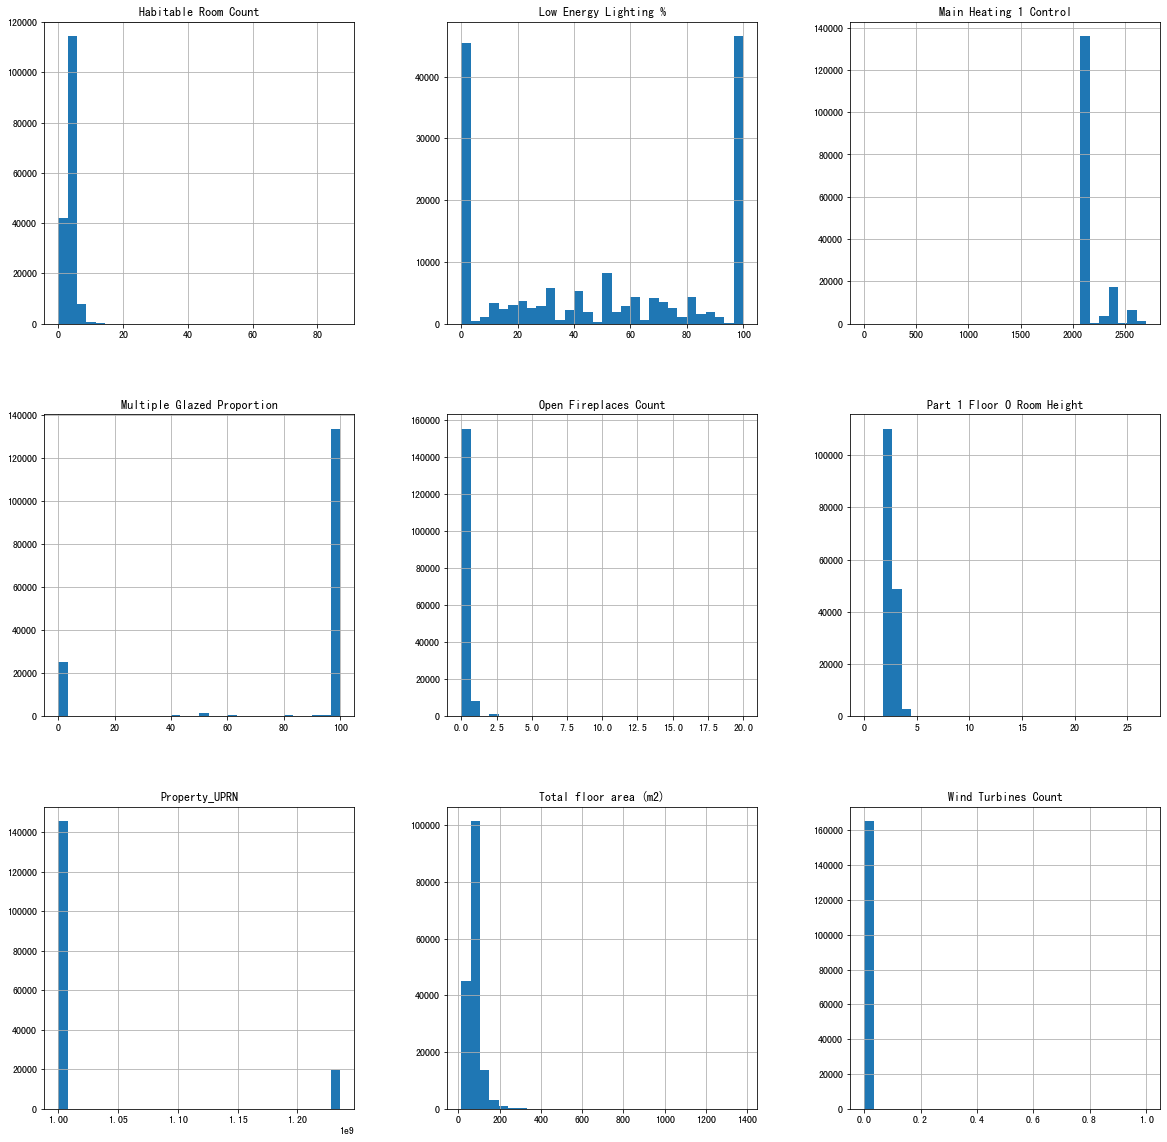

In [14]:
fig, ax = plt.subplots(figsize = (20,20))
epc[var_list_num].hist(bins=30,ax = ax)

Drop 'Wind Turbines Count', because 

In [15]:
epc.drop(['Wind Turbines Count'],
        axis = 1,
        inplace = True)
var_list_num.remove('Wind Turbines Count')

In [16]:
var_list_num.remove('Property_UPRN')

In [17]:
audit_num = epc[var_list_num].describe(percentiles = [0.25,0.5,0.75,0.9,0.95,0.99,0.9999])
audit_num

,Total floor area (m2),Low Energy Lighting %,Part 1 Floor 0 Room Height,Habitable Room Count,Main Heating 1 Control,Multiple Glazed Proportion,Open Fireplaces Count
count,165318.000000,165318.000000,161697.000000,165318.000000,165318.000000,165318.000000,165318.000000
mean,76.644939,49.401723,2.632778,3.193857,2166.282825,82.942583,0.076828
std,34.811742,40.416641,0.385971,1.542864,138.337790,36.634347,0.356913
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,0.000000,2.400000,2.000000,2106.000000,100.000000,0.000000
50%,71.000000,50.000000,2.500000,3.000000,2106.000000,100.000000,0.000000
75%,86.000000,100.000000,2.850000,4.000000,2107.000000,100.000000,0.000000
90%,109.000000,100.000000,3.150000,5.000000,2401.000000,100.000000,0.000000
95%,133.000000,100.000000,3.300000,6.000000,2404.000000,100.000000,1.000000
99%,203.000000,100.000000,3.790000,8.000000,2603.000000,100.000000,2.000000


clip

In [18]:
min = 0
maxPercentile = 0.9999
for _ in var_list_num:
    epc[_] =  epc[_].clip(0,(epc[_].quantile(maxPercentile)))

## Numeric features correrlations against the other fields in the taxonomy

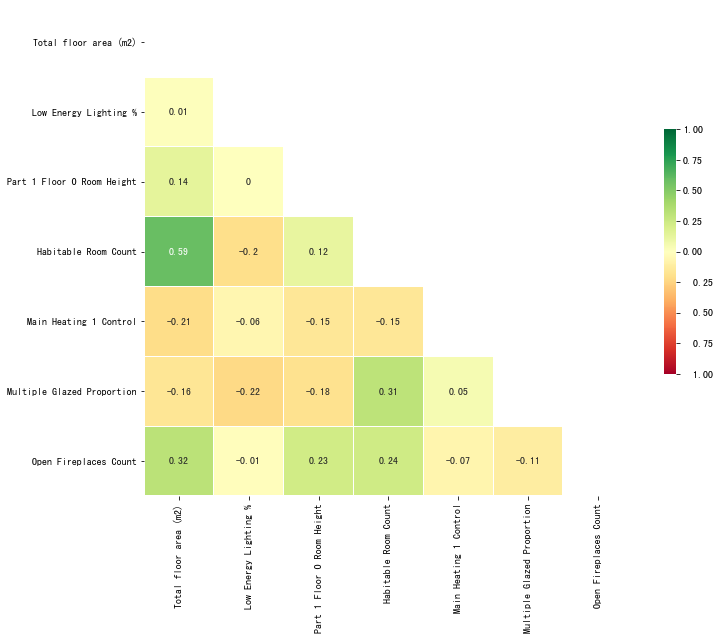

In [19]:
corr_all = epc[var_list_num].corr()

# plot correlations
corr_all = round(corr_all,2)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_all, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [20]:
epc.drop(['Habitable Room Count'],
        axis = 1,
        inplace = True)
var_list_num.remove('Habitable Room Count')

## Investigate categoric fields

In [21]:
var_list_cat = epc.select_dtypes(include= ['object']).columns.tolist()

In [22]:
# 调整位置

In [23]:
epc['Main Heating 1 Control'] = epc['Main Heating 1 Control'].round(0).astype(str)
var_list_num.remove('Main Heating 1 Control')
var_list_cat.append('Main Heating 1 Control')

In [24]:
epc[var_list_cat].isnull().sum().sort_values(ascending = False) / epc.shape[0]

LZC Energy Source                        0.953193
AIR_TIGHTNESS_DESCRIPTION                0.932578
Main Gas                                 0.769178
Heat Loss Corridor                       0.267672
Part 1 Construction Age Band             0.080245
Multiple Glazing Type                    0.067422
Meter Type                               0.067422
Solar Water Heating                      0.052904
Mechanical Ventilation                   0.048918
Photovoltaic Supply                      0.038544
Built Form                               0.006527
Main Heating 1 Fuel Type                 0.002728
Transaction Type                         0.000018
WINDOWS_DESCRIPTION                      0.000000
FLOOR_DESCRIPTION                        0.000000
ROOF_DESCRIPTION                         0.000000
MAINHEATCONT_DESCRIPTION                 0.000000
WALL_DESCRIPTION                         0.000000
MAINHEAT_DESCRIPTION                     0.000000
Main Heating 1 Control                   0.000000


Drop due to high percentage of missing values.

In [25]:
epc.drop(['LZC Energy Source','AIR_TIGHTNESS_DESCRIPTION','Main Gas','Heat Loss Corridor'],
                axis = 1,
                inplace = True)
var_list_cat.remove('LZC Energy Source')
var_list_cat.remove('AIR_TIGHTNESS_DESCRIPTION')
var_list_cat.remove('Main Gas')   
var_list_cat.remove('Heat Loss Corridor') 

In [26]:
var_list_cat

['Current energy efficiency rating band',
 'WALL_DESCRIPTION',
 'ROOF_DESCRIPTION',
 'FLOOR_DESCRIPTION',
 'WINDOWS_DESCRIPTION',
 'MAINHEAT_DESCRIPTION',
 'MAINHEATCONT_DESCRIPTION',
 'SECONDHEAT_DESCRIPTION',
 'HOTWATER_DESCRIPTION',
 'LIGHTING_DESCRIPTION',
 'Part 1 Construction Age Band',
 'Main Heating 1 Fuel Type',
 'Main Heating 1 Category',
 'Mechanical Ventilation',
 'Meter Type',
 'Multiple Glazing Type',
 'Photovoltaic Supply',
 'Solar Water Heating',
 'Built Form',
 'Property Type',
 'Transaction Type',
 'Main Heating 1 Control']

### Current energy efficiency rating band

In [27]:
epc['Current energy efficiency rating band'].unique()

array(['C', 'B', 'E', 'D', 'F', 'G', 'A'], dtype=object)

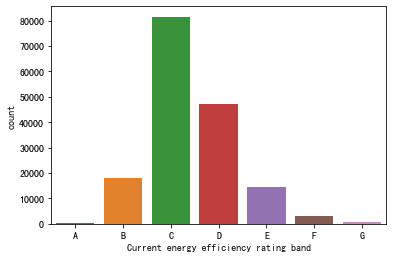

In [28]:
ax = sns.barplot(x="Current energy efficiency rating band", y="count", 
                 data=epc[['Property_UPRN','Current energy efficiency rating band']].groupby(['Current energy efficiency rating band']).count().reset_index().rename(columns = {"Property_UPRN":'count'}))

## var_list_cat

In [29]:
descriptive_columns = ['FLOOR_DESCRIPTION','LIGHTING_DESCRIPTION','ROOF_DESCRIPTION','WALL_DESCRIPTION',
                       'WINDOWS_DESCRIPTION','HOTWATER_DESCRIPTION','MAINHEATCONT_DESCRIPTION','MAINHEAT_DESCRIPTION']

for col in descriptive_columns:
    epc[col] = epc[col].str.replace(r"\|(.*)","")

In [30]:
def thermal_cleanup(df):
    
    ''' 
    standardising the wording in the variables containing average thermal transmittance. Specifically, 
    removing bi-lingual versions, removing =, translating welsh version, and standardising units
    Parameters
      df: a dataframe containing variables called 'FLOOR_DESCRIPTION','WALLS_DESCRIPTION','ROOF_DESCRIPTION'
    Returns a dataframe 
    '''
    
    for c in ['FLOOR_DESCRIPTION','WALL_DESCRIPTION','ROOF_DESCRIPTION']:
        df[c] = df[c].str.replace('  ',' ')
        df[c] = df[c].str.replace('Average thermal transmittance 1 ','Average thermal transmittance 1.00 ')
        df[c] = df[c].str.replace('Average thermal transmittance =','Average thermal transmittance')
        df[c] = df[c].str.replace('Trawsyriannedd thermol cyfartalog','Average thermal transmittance')
        # standardising the unit used
        df[c] = df[c].str.replace(r"W(.*?)K",'W/m²K')
        
    return df

In [31]:
epc = thermal_cleanup(epc)

### WALL_DESCRIPTION

In [32]:
len(set(epc['WALL_DESCRIPTION']))

126

In [33]:
epc['WALL_DESCRIPTION'].unique()

array(['Cavity wall, as built, partial insulation (assumed) ',
       'Cavity wall, with external insulation ',
       'Sandstone or limestone, as built, no insulation (assumed) ',
       'Cavity wall, with external insulation',
       'System built, with external insulation',
       'System built, as built, no insulation (assumed) ',
       'System built, as built, partial insulation (assumed) ',
       'Cavity wall, as built, no insulation (assumed) ',
       'Sandstone, as built, no insulation (assumed)',
       'Cavity wall, filled cavity ',
       'Cavity wall, as built, insulated (assumed) ',
       'Sandstone, as built, no insulation (assumed) ',
       'Cavity wall, as built, no insulation (assumed)',
       'System built, with external insulation ',
       'Cavity wall, filled cavity and external insulation ',
       'Average thermal transmittance 0.23 W/m²K ',
       'System built, as built, insulated (assumed)',
       'System built, as built, insulated (assumed) ',
       '

In [34]:
def walls_cleanup(df): 
    
    ''' 
    cleans-up the WALLS_DESCRIPTION feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'WALLS_DESCRIPTION'
    Returns a dataframe 
    '''
    
    # removing phrases like as built which aren't adding anything
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.lower()
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace(r"fel y(.*?)u hadeiladwyd, ","")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace(", as built","")
    # df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("cavity\.","cavity wall,")
    # df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("\(rhagdybiaeth\)","(assumed)")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace(" (assumed)","")
    # standardising punctuation
    # df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("solid brick\.","solid brick,")
    # standardising language
    # df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("granite or whin,","granite or whinstone,")
    # df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("stone \(granite or whin\)\.","granite or whinstone,")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("with external insulation","insulated")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("with internal insulation","insulated")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("with additional insulation","insulated")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("with insulation","insulated")
    # clean up
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace(r'\.$','')
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace('\+ chr\(13\) \+','+')
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("  \+"," +")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace("[ \t]+$","")
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace('timber frame\.','timber frame,')
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace('\?','')
    df['WALL_DESCRIPTION'] = df['WALL_DESCRIPTION'].str.replace('system built\.','system built,')
    
    return df

In [35]:
epc = walls_cleanup(epc)
len(set(epc['WALL_DESCRIPTION']))

74

In [36]:
def thermal_walls(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field
    Parameters
      df: a dataframe containing a variable called 'WALL_DESCRIPTION'
    Returns a dataframe 
    '''
    
    df['walls_average_thermal_transmittance'] = df['WALL_DESCRIPTION'].str.findall(r'\d.\d\d')
    df['walls_average_thermal_transmittance'] = round(df['walls_average_thermal_transmittance'].str[0].astype(float),1)
    df['WALL_DESCRIPTION'] = df.apply(lambda row: 'average thermal transmittance %.1f w/m²k' % (row['walls_average_thermal_transmittance']) if 'average' in str(row['WALL_DESCRIPTION']) else row['WALL_DESCRIPTION'],axis=1)
    
    return df

In [37]:
epc = thermal_walls(epc)
len(set(epc['WALL_DESCRIPTION']))

45

In [38]:
epc['WALL_DESCRIPTION'].unique()

array(['cavity wall, partial insulation (assumed)',
       'cavity wall, insulated',
       'sandstone or limestone, no insulation (assumed)',
       'system built, insulated', 'system built, no insulation (assumed)',
       'system built, partial insulation (assumed)',
       'cavity wall, no insulation (assumed)',
       'sandstone, no insulation (assumed)', 'cavity wall, filled cavity',
       'cavity wall, insulated (assumed)',
       'cavity wall, filled cavity and external insulation',
       'average thermal transmittance 0.2 w/m²k',
       'system built, insulated (assumed)',
       'timber frame, insulated (assumed)',
       'sandstone or limestone, insulated',
       'sandstone or limestone, insulated (assumed)',
       'solid brick, insulated (assumed)',
       'solid brick, no insulation (assumed)',
       'timber frame, no insulation (assumed)', 'sandstone, insulated',
       'granite or whinstone, no insulation (assumed)',
       'sandstone or limestone, partial insulatio

### ROOF_DESCRIPTION

In [40]:
len(epc['ROOF_DESCRIPTION'].unique())

121

In [41]:
epc['ROOF_DESCRIPTION'].unique()

array(['Pitched, 300 mm loft insulation ', '(another dwelling above) ',
       'Pitched, 250 mm loft insulation',
       'Pitched, 100 mm loft insulation ',
       'Pitched, 150 mm loft insulation ', '(another dwelling above)',
       'Flat, limited insulation (assumed)',
       'Pitched, 100 mm loft insulation', 'Pitched, no insulation ',
       'Pitched, insulated (assumed) ', 'Flat, no insulation (assumed)',
       'Pitched, no insulation (assumed)',
       'Pitched, 270 mm loft insulation ',
       'Pitched, 400 mm loft insulation ',
       'Pitched, 250 mm loft insulation ',
       'Pitched, 75 mm loft insulation ',
       'Pitched, no insulation (assumed) ',
       'Pitched, 200 mm loft insulation ',
       'Pitched, 12 mm loft insulation ', '(other premises above) ',
       'Average thermal transmittance 0.12 W/m²K ',
       'Pitched, no insulation', 'Pitched, 50 mm loft insulation ',
       'Flat, insulated (assumed) ',
       'Pitched, limited insulation (assumed)',
       'Fl

In [42]:
def roof_cleanup(df):
    
    ''' 
    cleans-up the ROOF_DESCRIPTION feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'ROOF_DESCRIPTION'
    Returns a dataframe 
    '''
    
    # standardising units
    # df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace(" mm",'mm')
    # df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace(">= 300mm",">=300mm")
    # df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace(">=300mm","300+mm")
    
    # standardising descriptions
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("Roof room,","Roof room(s),")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("annedd arall uwchben","other premises above")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("another dwelling above","other premises above")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("Dwelling Above","(other premises above)")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace(r"0 W/m²K",r" W/m²K")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("  W/m²K"," 0.0 W/m²K")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("Roof room\(s\), no insulation\(assumed\)","Roof room(s), no insulation (assumed)")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("Other premises above","(other premises above)")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("\(assumed\)","")
    # cleanup
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace(r'\.$','')
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace('0m','0 m')
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace('5m','5 m')
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace('2m','2 m')
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("  "," ")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace(r'\,$','')
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("  \+"," +")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("[ \t]+$","")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("mmmm","mm")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("Thatchedinsulated","Thatched, insulated")
    df['ROOF_DESCRIPTION'] = df['ROOF_DESCRIPTION'].str.replace("\*\*\* INVALID INPUT Code \: 57 \*\*\*","")
    
    return df

In [43]:
epc = roof_cleanup(epc)
len(set(epc['ROOF_DESCRIPTION']))

52

In [44]:
def thermal_roof(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field
    Parameters
      df: a dataframe containing a variable called 'ROOF_DESCRIPTION'
    Returns a dataframe 
    '''
    
    df['roof_average_thermal_transmittance'] = df['ROOF_DESCRIPTION'].str.findall(r'(\d.\d*) W/m²K')
    df['roof_average_thermal_transmittance'] = round(df['roof_average_thermal_transmittance'].str[0].astype(float),1)
    df['ROOF_DESCRIPTION'] = df.apply(lambda row: 'average thermal transmittance %.1f W/m²k' % (row['roof_average_thermal_transmittance']) if 'Average' in str(row['ROOF_DESCRIPTION']) else row['ROOF_DESCRIPTION'],axis=1)
    
    return df

In [45]:
epc = thermal_roof(epc)
len(set(epc['ROOF_DESCRIPTION']))

36

In [46]:
epc['ROOF_DESCRIPTION'].unique()

array(['Pitched, 300 mm loft insulation', '(other premises above)',
       'Pitched, 250 mm loft insulation',
       'Pitched, 100 mm loft insulation',
       'Pitched, 150 mm loft insulation', 'Flat, limited insulation',
       'Pitched, no insulation', 'Pitched, insulated',
       'Flat, no insulation', 'Pitched, 270 mm loft insulation',
       'Pitched, 400 mm loft insulation',
       'Pitched, 75 mm loft insulation',
       'Pitched, 200 mm loft insulation',
       'Pitched, 12 mm loft insulation',
       'average thermal transmittance 0.1 W/m²k',
       'Pitched, 50 mm loft insulation', 'Flat, insulated',
       'Pitched, limited insulation', 'Pitched, 300+ mm loft insulation',
       'Pitched, 400+ mm loft insulation', 'Roof room(s), insulated',
       'average thermal transmittance 0.2 W/m²k',
       'Pitched, 25 mm loft insulation',
       'Pitched, 350 mm loft insulation',
       'Roof room(s), ceiling insulated', 'Pitched, insulated at rafters',
       'Roof room(s), limited 

In [47]:
cnt = Counter(epc['ROOF_DESCRIPTION'])
cnt

Counter({'Pitched, 300 mm loft insulation': 8751,
         '(other premises above)': 85059,
         'Pitched, 250 mm loft insulation': 9602,
         'Pitched, 100 mm loft insulation': 6256,
         'Pitched, 150 mm loft insulation': 5135,
         'Flat, limited insulation': 1061,
         'Pitched, no insulation': 14806,
         'Pitched, insulated': 3092,
         'Flat, no insulation': 559,
         'Pitched, 270 mm loft insulation': 3717,
         'Pitched, 400 mm loft insulation': 192,
         'Pitched, 75 mm loft insulation': 900,
         'Pitched, 200 mm loft insulation': 8330,
         'Pitched, 12 mm loft insulation': 646,
         'average thermal transmittance 0.1 W/m²k': 5524,
         'Pitched, 50 mm loft insulation': 2027,
         'Flat, insulated': 1569,
         'Pitched, limited insulation': 1303,
         'Pitched, 300+ mm loft insulation': 2409,
         'Pitched, 400+ mm loft insulation': 553,
         'Roof room(s), insulated': 173,
         'average thermal

### Floor_DESCRIPTION

In [48]:
len(set(epc['FLOOR_DESCRIPTION']))

70

In [49]:
epc['FLOOR_DESCRIPTION'].unique()

array(['(another dwelling below) ', 'Suspended, insulated ',
       '(other premises below)', 'Suspended, no insulation (assumed) ',
       'Suspended, no insulation (assumed)', '(other premises below) ',
       'Suspended, limited insulation (assumed) ',
       'Suspended, insulated (assumed) ',
       'Solid, no insulation (assumed) ',
       'Average thermal transmittance 0.18 W/m²K ',
       'To external air, insulated (assumed) ',
       'Solid, insulated (assumed) ', 'Solid, insulated (assumed)',
       'Solid, limited insulation (assumed) ',
       'Solid, no insulation (assumed)', 'Suspended, insulated (assumed)',
       'To unheated space, limited insulation (assumed) ',
       'Suspended, limited insulation (assumed)',
       'Average thermal transmittance 0.11 W/m²K ',
       'Average thermal transmittance 0.10 W/m²K ',
       'Average thermal transmittance 0.09 W/m²K ',
       'Average thermal transmittance 0.08 W/m²K ',
       'Average thermal transmittance 0.15 W/m²K ',
 

In [50]:
def thermal_floor(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field to 1 decimal place
    Parameters
      df: a dataframe containing a variable called 'FLOOR_DESCRIPTION'
    Returns a dataframe 
    '''
    
    # finds the decimal number
    df['floors_average_thermal_transmittance'] = df['FLOOR_DESCRIPTION'].str.findall(r'\d.\d*')
    # rounds the number to 1 decimal place
    df['floors_average_thermal_transmittance'] = round(df['floors_average_thermal_transmittance'].str[0].astype(float),1)
    # 
    df['FLOOR_DESCRIPTION'] = df.apply(lambda row: 'average thermal transmittance %.1f W/m²K' % (row['floors_average_thermal_transmittance']) if 'Average' in str(row['FLOOR_DESCRIPTION']) else row['FLOOR_DESCRIPTION'],axis=1)
    
    return df

In [51]:
epc = thermal_floor(epc)
len(set(epc['FLOOR_DESCRIPTION']))

41

In [52]:
def floor_cleanup(df):
    
    ''' 
    cleans-up the FLOOR_DESCRIPTION feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'FLOOR_DESCRIPTION'
    Returns a dataframe 
    ''' 
    # standardising descriptions
    df['FLOOR_DESCRIPTION'] = df['FLOOR_DESCRIPTION'].str.replace(" (assumed)","")
    df['FLOOR_DESCRIPTION'] = df['FLOOR_DESCRIPTION'].str.replace("another dwelling below","other premises below")
    df['FLOOR_DESCRIPTION'] = df['FLOOR_DESCRIPTION'].str.strip(" ")
    
    return df

In [53]:
epc = floor_cleanup(epc)
len(set(epc['FLOOR_DESCRIPTION']))

24

In [54]:
epc['FLOOR_DESCRIPTION'].unique()

array(['(other premises below)', 'Suspended, insulated',
       'Suspended, no insulation (assumed)',
       'Suspended, limited insulation (assumed)',
       'Suspended, insulated (assumed)', 'Solid, no insulation (assumed)',
       'average thermal transmittance 0.2 W/m²K',
       'To external air, insulated (assumed)',
       'Solid, insulated (assumed)',
       'Solid, limited insulation (assumed)',
       'To unheated space, limited insulation (assumed)',
       'average thermal transmittance 0.1 W/m²K',
       'To unheated space, no insulation (assumed)',
       'To unheated space, insulated (assumed)',
       'To external air, no insulation (assumed)',
       'To unheated space, insulated', 'Solid, insulated',
       'no insulation (assumed)',
       'To external air, limited insulation (assumed)',
       '(Same dwelling below) insulated (assumed)',
       'To external air, insulated',
       'average thermal transmittance 0.0 W/m²K',
       'average thermal transmittance 0.4 W/

### WINDOWS DESCRIPTION

In [56]:
len(set(epc['WINDOWS_DESCRIPTION']))

36

In [57]:
epc['WINDOWS_DESCRIPTION'].unique()

array(['Description: Fully double glazed ',
       'Description: Fully double glazed', 'Description: Single glazed ',
       'Description: Partial double glazing ',
       'Description: High performance glazing ',
       'Description: Some double glazing ', 'Description: Single glazed',
       'Description: Partial double glazing',
       'Description: Some double glazing',
       'Description: Some secondary glazing ',
       'Description: High performance glazing',
       'Description: Fully triple glazed ',
       'Description: Partial secondary glazing ',
       'Description: Mostly double glazing ',
       'Description: Mostly double glazing',
       'Description: Full secondary glazing ',
       'Description: Partial triple glazing ',
       'Description: Multiple glazing throughout ',
       'Description: Single glazeddouble glazing',
       'Description: Mostly secondary glazing ',
       'Description: Partial secondary glazing',
       'Description: Some secondary glazing',
  

In [58]:
def windows_cleanup(df):
    
    # standardising descriptions
    df['WINDOWS_DESCRIPTION'] = df['WINDOWS_DESCRIPTION'].str.strip(" ")
    df['WINDOWS_DESCRIPTION'] = df['WINDOWS_DESCRIPTION'].str.replace("Single glazeddouble glazing","Single glazed and double glazing")
    df['WINDOWS_DESCRIPTION'] = df['WINDOWS_DESCRIPTION'].str.replace("Single glazedsecondary glazing","Single glazed and secondary glazing")
    return df

In [59]:
epc = windows_cleanup(epc)
len(set(epc['WINDOWS_DESCRIPTION']))

20

In [60]:
epc['WINDOWS_DESCRIPTION'].unique()

array(['Description: Fully double glazed', 'Description: Single glazed',
       'Description: Partial double glazing',
       'Description: High performance glazing',
       'Description: Some double glazing',
       'Description: Some secondary glazing',
       'Description: Fully triple glazed',
       'Description: Partial secondary glazing',
       'Description: Mostly double glazing',
       'Description: Full secondary glazing',
       'Description: Partial triple glazing',
       'Description: Multiple glazing throughout',
       'Description: Single glazed and double glazing',
       'Description: Mostly secondary glazing',
       'Description: Mostly triple glazing',
       'Description: Fully secondary glazing',
       'Description: Partial multiple glazing',
       'Description: Some triple glazing',
       'Description: Single glazed and secondary glazing',
       'Description: Mostly multiple glazing'], dtype=object)

### MAINHEAT DESCRIPTION

In [62]:
len(set(epc['MAINHEAT_DESCRIPTION']))

67

In [63]:
epc['MAINHEAT_DESCRIPTION'].unique()

array(['Boiler and radiators, mains gas ',
       'Boiler and radiators, mains gas', 'Community scheme',
       'Community scheme ', 'Electric storage heaters ',
       'Room heaters, electric ', 'Electric storage heaters',
       'No system present: electric heaters assumed ',
       'Boiler and radiators, electric ',
       'Boiler and underfloor heating, mains gas ',
       'Room heaters, electric',
       'No system present: electric heaters assumed',
       'Boiler and radiators, LPG ', 'Boiler and radiators, electric',
       'Room heaters, mains gas ', 'Air source heat pump , electric ',
       'Warm air, Electricaire', 'Boiler and radiators, LPG',
       'Room heaters, mains gas',
       'Air source heat pump, Systems with radiators, electric ',
       'Electric underfloor heating', 'Electric underfloor heating ',
       'Boiler and underfloor heating, electric ',
       'Warm air, Electricaire ',
       'Boiler and underfloor heating, mains gas', 'Boiler, mains gas ',
       '

In [64]:
def mainheat_cleanup(df):
    
    # standardising descriptions
    df['MAINHEAT_DESCRIPTION'] = df['MAINHEAT_DESCRIPTION'].str.strip(" ")
    
    return df

In [65]:
epc = mainheat_cleanup(epc)
len(set(epc['MAINHEAT_DESCRIPTION']))

43

In [66]:
epc['MAINHEAT_DESCRIPTION'].unique()

array(['Boiler and radiators, mains gas', 'Community scheme',
       'Electric storage heaters', 'Room heaters, electric',
       'No system present: electric heaters assumed',
       'Boiler and radiators, electric',
       'Boiler and underfloor heating, mains gas',
       'Boiler and radiators, LPG', 'Room heaters, mains gas',
       'Air source heat pump , electric', 'Warm air, Electricaire',
       'Air source heat pump, Systems with radiators, electric',
       'Electric underfloor heating',
       'Boiler and underfloor heating, electric', 'Boiler, mains gas',
       'Room heaters, coal', 'Warm air, mains gas',
       'Air source heat pump, radiators, electric',
       'Air source heat pump, underfloor, electric',
       'Portable electric heaters assumed for most rooms',
       'Boiler and radiators, oil', 'Electric ceiling heating',
       'Water source heat pump, radiators, electric',
       'Electric ceiling heating, electric',
       'Boiler and radiators, anthracite',
    

### MAINHEATCONT DESCRIPTION

In [68]:
len(set(epc['MAINHEATCONT_DESCRIPTION']))

76

In [69]:
epc['MAINHEATCONT_DESCRIPTION'].unique()

array(['Programmer, TRVs and bypass ',
       'Programmer, room thermostat and TRVs ',
       'Programmer, TRVs and bypass',
       'Flat rate charging, programmer and room thermostat',
       'Flat rate charging, TRVs',
       'Flat rate charging, programmer and TRVs ',
       'Charging system linked to use of community heating, programmer and room thermostat ',
       'Manual charge control ', 'Appliance thermostats ',
       'Automatic charge control ', 'Manual charge control',
       'Programmer and appliance thermostats ',
       'Programmer, room thermostat and TRVs', 'None ',
       'Room thermostat only ', 'Programmer, no room thermostat ',
       'Controls for high heat retention storage heaters ',
       'Programmer and room thermostat ',
       'Time and temperature zone control ',
       'No time or thermostatic control of room temperature ',
       'Flat rate charging, TRVs ',
       'Charging system linked to use of community heating, programmer and TRVs ',
       'Flat r

In [70]:
def heat_control_cleanup(df):
  
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.lower()

    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("__¢_¢__¬_¢__¢","")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("____¢","")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("2207","")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("none","")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.strip(" ")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("system dalu wedii chysylltu  defnyddio gwres cymunedol, trvs","charging system linked to use of community heating, trvs")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("rhaglennydd a thermostatau ystafell","programmer and room thermostats")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("rhaglennydd, thermostat ystafell a trvs","programmer, room thermostat and trvs")
    df['MAINHEATCONT_DESCRIPTION'] = df['MAINHEATCONT_DESCRIPTION'].str.replace("","")
    
    return df

In [71]:
epc = heat_control_cleanup(epc)
len(set(epc['MAINHEATCONT_DESCRIPTION']))

37

In [72]:
epc['MAINHEATCONT_DESCRIPTION'].unique()

array(['programmer, trvs and bypass',
       'programmer, room thermostat and trvs',
       'flat rate charging, programmer and room thermostat',
       'flat rate charging, trvs',
       'flat rate charging, programmer and trvs',
       'charging system linked to use of community heating, programmer and room thermostat',
       'manual charge control', 'appliance thermostats',
       'automatic charge control', 'programmer and appliance thermostats',
       '', 'room thermostat only', 'programmer, no room thermostat',
       'controls for high heat retention storage heaters',
       'programmer and room thermostat',
       'time and temperature zone control',
       'no time or thermostatic control of room temperature',
       'charging system linked to use of community heating, programmer and trvs',
       'no thermostatic control of room temperature',
       'room thermostats only', 'trvs and bypass',
       'charging system linked to use of community heating, trvs',
       'flat ra

### HOTWATER DESCRIPTINO

In [74]:
len(set(epc['HOTWATER_DESCRIPTION']))

54

In [75]:
epc['HOTWATER_DESCRIPTION'].unique()

array(['From main system ', 'From main system', 'Community scheme',
       'Electric immersion, standard tariff',
       'Electric instantaneous at point of use ',
       'Community scheme, no cylinder thermostat ',
       'Electric immersion, standard tariff ',
       'Electric immersion, off-peak ', 'Electric immersion, off-peak',
       'From main system, no cylinder thermostat ', 'Community scheme ',
       'Electric instantaneous at point of use',
       'From main system, flue gas heat recovery ',
       'Gas range cooker, no cylinder thermostat',
       'No system present: electric immersion assumed ',
       'From main system, no cylinder thermostat',
       'No system present: electric immersion assumed',
       'Gas instantaneous at point of use',
       'Electric instantaneous at point of use, waste water heat recovery ',
       'Electric heat pump for water heating only ',
       'From main system, waste water heat recovery ',
       'Gas boiler/circulator, no cylinder ther

In [76]:
def hotwater_cleanup(df):
 
    # removing spaces at the end
    df['HOTWATER_DESCRIPTION'] = df['HOTWATER_DESCRIPTION'].str.strip(" ")

    return df

In [77]:
epc = hotwater_cleanup(epc)
len(set(epc['HOTWATER_DESCRIPTION']))

34

In [78]:
epc['HOTWATER_DESCRIPTION'].unique()

array(['From main system', 'Community scheme',
       'Electric immersion, standard tariff',
       'Electric instantaneous at point of use',
       'Community scheme, no cylinder thermostat',
       'Electric immersion, off-peak',
       'From main system, no cylinder thermostat',
       'From main system, flue gas heat recovery',
       'Gas range cooker, no cylinder thermostat',
       'No system present: electric immersion assumed',
       'Gas instantaneous at point of use',
       'Electric instantaneous at point of use, waste water heat recovery',
       'Electric heat pump for water heating only',
       'From main system, waste water heat recovery',
       'Gas boiler/circulator, no cylinder thermostat',
       'Gas boiler/circulator', 'Community scheme, plus solar',
       'Gas multipoint', 'Electric immersion, off-peak, plus solar',
       'From secondary system', 'Gas range cooker',
       'From main system, plus solar',
       'From secondary system, no cylinder thermostat

### LIGHTING DESCRIPTION

In [79]:
len(set(epc['LIGHTING_DESCRIPTION']))

202

In [80]:
epc['LIGHTING_DESCRIPTION'].unique()

array(['Low energy lighting in all fixed outlets ',
       'Low energy lighting in 14% of fixed outlets',
       'Low energy lighting in 17% of fixed outlets ',
       'Low energy lighting in 33% of fixed outlets ',
       'No low energy lighting',
       'Low energy lighting in 38% of fixed outlets ',
       'No low energy lighting ',
       'Low energy lighting in all fixed outlets',
       'Low energy lighting in 20% of fixed outlets ',
       'Low energy lighting in 15% of fixed outlets ',
       'Low energy lighting in 83% of fixed outlets ',
       'Low energy lighting in 50% of fixed outlets ',
       'Low energy lighting in 54% of fixed outlets ',
       'Low energy lighting in 67% of fixed outlets',
       'Low energy lighting in 75% of fixed outlets ',
       'Low energy lighting in 17% of fixed outlets',
       'Low energy lighting in 40% of fixed outlets ',
       'Low energy lighting in 40% of fixed outlets',
       'Low energy lighting in 14% of fixed outlets ',
       'L

In [81]:
def lighting_perc_cleanup(df):
    
    ''' 
    rounds the low energy lighting percentage figure which is within a str field
    Parameters
      df: a dataframe containing a variable called 'LIGHTING_DESCRIPTION'
    Returns a dataframe 
    '''
    df['LIGHTING_DESCRIPTION'] = df['LIGHTING_DESCRIPTION'].str.strip(" ")
    df['LIGHTING_DESCRIPTION'] = df['LIGHTING_DESCRIPTION'].str.lower() 
    df['low_energy_lighting_perc'] = df['LIGHTING_DESCRIPTION'].str.findall(r'(\d*)\%')
    df['low_energy_lighting_perc'] = round(df['low_energy_lighting_perc'].str[0].astype(float),-1)
    df['LIGHTING_DESCRIPTION'] = df.apply(lambda row: 'low energy lighting %d%% of fixed outlets' % (int(row['low_energy_lighting_perc'])) if '%' in str(row['LIGHTING_DESCRIPTION']) else row['LIGHTING_DESCRIPTION'],axis=1)
    df['LIGHTING_DESCRIPTION'] = df['LIGHTING_DESCRIPTION'].str.replace("low energy lighting in all fixed outlets","low energy lighting 100% of fixed outlets")
    
    return df

In [82]:
epc = lighting_perc_cleanup(epc)

In [83]:
len(set(epc['LIGHTING_DESCRIPTION']))

12

In [84]:
epc['LIGHTING_DESCRIPTION'].unique()

array(['low energy lighting 100% of fixed outlets',
       'low energy lighting 10% of fixed outlets',
       'low energy lighting 20% of fixed outlets',
       'low energy lighting 30% of fixed outlets',
       'no low energy lighting',
       'low energy lighting 40% of fixed outlets',
       'low energy lighting 80% of fixed outlets',
       'low energy lighting 50% of fixed outlets',
       'low energy lighting 70% of fixed outlets',
       'low energy lighting 90% of fixed outlets',
       'low energy lighting 60% of fixed outlets',
       'low energy lighting 0% of fixed outlets'], dtype=object)

### Part 1 Construction Age Band

In [85]:
epc['Part 1 Construction Age Band'].unique()

array(['1976-1983', '1950-1964', 'before 1919', '1965-1975', '1930-1949',
       '1984-1991', '1992-1998', '1919-1929', '2003-2007', '1999-2002',
       nan, '2008 onwards'], dtype=object)

In [86]:
epc[epc['Part 1 Construction Age Band'].isna()].shape

(13266, 32)

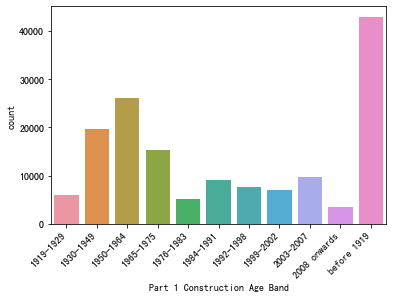

In [87]:
ax = sns.barplot(x="Part 1 Construction Age Band", y="count", 
                 data = epc[['Property_UPRN','Part 1 Construction Age Band']].groupby(['Part 1 Construction Age Band']).count().reset_index().rename(columns = {"Property_UPRN":'count'}))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

### Solar Water Heating

In [88]:
epc['Solar Water Heating'].unique()

array(['N', 'FALSE', nan, 'TRUE', 'Y'], dtype=object)

In [89]:
def solar_cleanup(df):

    df['Solar Water Heating'] = df['Solar Water Heating'].str.replace("FALSE","N")
    df['Solar Water Heating'] = df['Solar Water Heating'].str.replace("TRUE","Y")
    df['Solar Water Heating'] = df['Solar Water Heating'].fillna('nan')
    return df

In [90]:
epc = solar_cleanup(epc)

In [91]:
epc['Solar Water Heating'].unique()

array(['N', 'nan', 'Y'], dtype=object)

### Main Heating 1 Fuel Type

In [92]:
epc['Main Heating 1 Fuel Type'].unique()

array(['mains gas (not community)', 'mains gas (community)',
       'electricity (not community)',
       'no heating/hot-water system or data is from a community network',
       'Gas: mains gas', 'electricity (community)', 'LPG (not community)',
       'biomass (community)',
       'Electricity: electricity, unspecified tariff', nan,
       'house coal (community)', 'oil (not community)', 'bottled LPG',
       'anthracite', 'dual fuel - mineral + wood', 'smokeless coal',
       'bulk wood pellets', 'oil (community)', 'B30K (not community)',
       'biogas (not community)',
       'appliances able to use mineral oil or liquid biofuel'],
      dtype=object)

### Main Heating 1 Category

In [94]:
epc['Main Heating 1 Category'].unique()

array(['boiler with radiators or underfloor heating',
       'community heating system', 'electric storage heaters',
       'room heaters', 'none',
       'heat pump with radiators or underfloor heating',
       'warm air system (not heat pump)', 'electric underfloor heating',
       'other system', 'not recorded',
       'heat pump with warm air distribution'], dtype=object)

### Main Heating 1 Control

In [95]:
epc['Main Heating 1 Control'].unique()

array(['2107', '2106', '2304', '2307', '2305', '2309', '2401', '2602',
       '2402', '2603', '2699', '2103', '2102', '2404', '2104', '2110',
       '2101', '2306', '2601', '2604', '2111', '2310', '2302', '2105',
       '2312', '2207', '2503', '2109', '2706', '2705', '2704', '2301',
       '2303', '2605', '2504', '2703', '2204', '2501', '2311', '2206',
       '2308', '2702', '0', '2701', '2112', '2205', '2502', '2506',
       '2208', '2100', '2203', '2108', '2202'], dtype=object)

### Mechanical Ventilation

In [96]:
epc['Mechanical Ventilation'].unique()

array(['natural', 'mechanical, extract only',
       'mechanical, supply and extract', nan], dtype=object)

### Multiple Glazed Proportion

In [97]:
epc['Multiple Glazed Proportion'].unique()

array([100,   0,  57,  50,  20,  40,  43,  13,  10,   1,  63,  71,  67,
        98,  60,  83,  38,  70,  85,  29,  30,  28,  75,  66,  25,  88,
        90,  11,  35,  42,  16,  84,  95,  80,  22,  97,  87,  81,  82,
        17,  45,  15,  34,  14,  55,  65,  86,  56,  62,  33,  94,   5,
        46,  73,  44,  64,  36,  58,  89,  32,  21,  96,  93,  12,  26,
         7,  91,  23,  27,  92,  47,  72,  78,  18,  31,   9,  77,  99,
         8,  24,  37,  59,   2,   6,  79,  54,  48,  53,  39,  68,  69,
        19,  74,  52,  61,  76,  41,   4,   3])

### Multiple Glazing Type

In [98]:
epc['Multiple Glazing Type'].unique()

array(['double glazing installed before 2002',
       'double glazing installed during or after 2002',
       'double glazing, unknown install date', 'not defined', nan,
       'secondary glazing', 'triple, known data', 'triple glazing',
       'single glazing', 'double, known data'], dtype=object)

### Transaction Type

In [99]:
epc['Transaction Type'].unique()

array(['rental', 'marketed sale', 'none of the above', 'ECO assessment',
       'assessment for green deal', 'new dwelling', 'non marketed sale',
       'FiT application', 'following green deal', 'RHI application', nan,
       'rental (private)', 'rental (social)'], dtype=object)

### Built Form

In [100]:
epc['Built Form'].unique()

array(['Mid-Terrace', 'Detached', 'End-Terrace', 'Semi-Detached',
       'Enclosed Mid-Terrace', 'Enclosed End-Terrace', nan], dtype=object)

### Property Type

In [101]:
epc['Property Type'].unique()

array(['Flat', 'Bungalow', 'House', 'Maisonette', 'Park home'],
      dtype=object)

## Combine categorical variables 

### Built Form

In [109]:
built_dict = dict.fromkeys(['Mid-Terrace','End-Terrace','Enclosed Mid-Terrace','Enclosed End-Terrace'],'terraced')
built_dict1 = dict.fromkeys(['Semi-Detached','Detached'],'detached')
built_dict.update(built_dict1)

In [110]:
epc['built_form'] =epc['Built Form'].replace(built_dict)

In [111]:
epc['built_form'].unique()

array(['terraced', 'detached', nan], dtype=object)

In [113]:
epc = epc.drop(columns = ['Built Form'])

## Drop columns

In [115]:
epc.columns

Index(['Property_UPRN', 'Total floor area (m2)',
       'Current energy efficiency rating band', 'WALL_DESCRIPTION',
       'ROOF_DESCRIPTION', 'FLOOR_DESCRIPTION', 'WINDOWS_DESCRIPTION',
       'MAINHEAT_DESCRIPTION', 'MAINHEATCONT_DESCRIPTION',
       'SECONDHEAT_DESCRIPTION', 'HOTWATER_DESCRIPTION',
       'LIGHTING_DESCRIPTION', 'Part 1 Construction Age Band',
       'Low Energy Lighting %', 'Part 1 Floor 0 Room Height',
       'Main Heating 1 Fuel Type', 'Main Heating 1 Category',
       'Main Heating 1 Control', 'Mechanical Ventilation', 'Meter Type',
       'Multiple Glazed Proportion', 'Multiple Glazing Type',
       'Open Fireplaces Count', 'Photovoltaic Supply', 'Solar Water Heating',
       'Property Type', 'Transaction Type',
       'walls_average_thermal_transmittance',
       'roof_average_thermal_transmittance',
       'floors_average_thermal_transmittance', 'low_energy_lighting_perc',
       'built_form'],
      dtype='object')

In [116]:
fields_to_drop = ['walls_average_thermal_transmittance','roof_average_thermal_transmittance',
                 'floors_average_thermal_transmittance','low_energy_lighting_perc']
epc.drop(fields_to_drop,axis = 1,inplace=True)

In [117]:
epc.columns

Index(['Property_UPRN', 'Total floor area (m2)',
       'Current energy efficiency rating band', 'WALL_DESCRIPTION',
       'ROOF_DESCRIPTION', 'FLOOR_DESCRIPTION', 'WINDOWS_DESCRIPTION',
       'MAINHEAT_DESCRIPTION', 'MAINHEATCONT_DESCRIPTION',
       'SECONDHEAT_DESCRIPTION', 'HOTWATER_DESCRIPTION',
       'LIGHTING_DESCRIPTION', 'Part 1 Construction Age Band',
       'Low Energy Lighting %', 'Part 1 Floor 0 Room Height',
       'Main Heating 1 Fuel Type', 'Main Heating 1 Category',
       'Main Heating 1 Control', 'Mechanical Ventilation', 'Meter Type',
       'Multiple Glazed Proportion', 'Multiple Glazing Type',
       'Open Fireplaces Count', 'Photovoltaic Supply', 'Solar Water Heating',
       'Property Type', 'Transaction Type', 'built_form'],
      dtype='object')

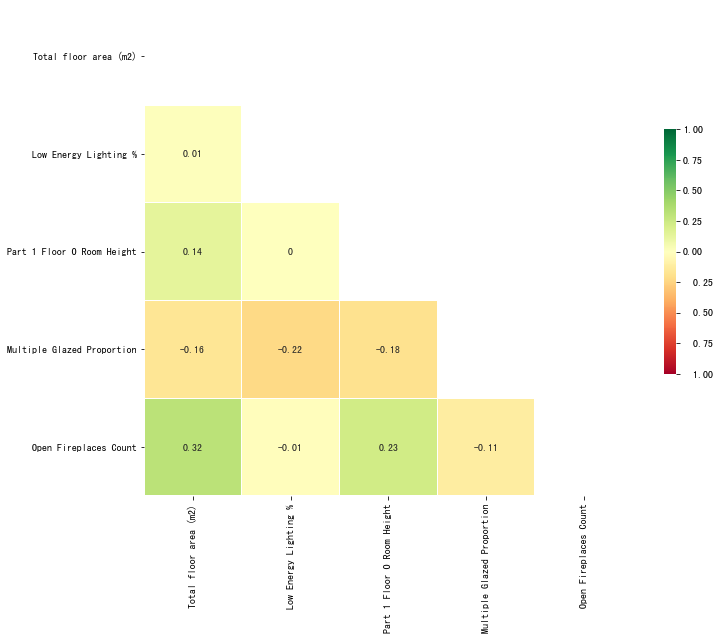

In [119]:
# plot correlations
test_corr = epc.copy().drop(columns = ['Property_UPRN'])
corr_all = test_corr.corr()
corr_all = round(corr_all,2)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_all, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()